In [1]:
import os

import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import matplotlib.cm as cm
import numpy as np
import datetime as dt
import math

From Phil:
- The river discharge has not changed in the new version.  However there is an annoying twist that I think is not accounted for in your previous code, so you might find that my real river discharge numbers disagree for real rivers 15 and 16.  The twist is that these two real rivers correspond to only one model river, so the discharge must be split between the two real rivers (I do this weighting by catchment area), otherwise you will double-count the discharge for these two rivers combined.
- When you make your modified netcdf file (for the given scenario), it would be great if you could add some brief text to the ‘history’ attribute.  Here you can refer to the scripts used to make the modifications.  It’s just nice to have this info bundled in with the file, so that we can see roughly how it was produced with ‘ncdump -h’

# User input

In [2]:
fpath_baseline_data = r"/home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/martini_rivers_v9_1990_2022_stage1data.nc"
real_riv_metadata = r"../data/real_river_metadata.csv"
riv_no_mapping_fpath = (
    r"/home/jovyan/shared/common/oslofjord_modelling/oslofjord_location_ids.csv"
)
# Scenarios info
scenario_setup_fpath = r"../data/md_of800_scenarios.csv"

# Folders for output files
netcdf_outfolder = r"/home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/river_scenarios"

start_year = 2013  # 2016
end_year = 2022

# Folder to save output in
fig_folder = r"../output/plots"
scenario_data_folder = r"/home/jovyan/shared/common/oslofjord_modelling/MARTINI800v10_river_inputs/scenarios"

# River numbers of interest
oslofjord_riv_nos = range(6, 21)  # Real river numbers
# (Model numbers 5 to 25 incl.)

# Generate scenarios for N or P species? Should be one of the TEOTIL parameter names
# Possibles (see TEOTIL results file): 'din', 'ton', 'totn', 'tdp', 'tpp', 'totp'
# NOTE: code doesn't work with all of these yet. E.g. 'ton' has no lake deposition input
par = "din"

# Set up & read in river metadata

In [3]:
if par in ['din', 'ton', 'totn']:
    species = 'N'
elif par in ['tdp', 'tpp', 'totp']:
    species = 'P'

riv_var_li_dict = {
    "N": [
        "river_NH4N",
        "river_NO3NO2N",
        "river_TOTN",
        "river_DON",
        "river_PON",
        "river_transport",
    ],
    "P": [
        "river_SRP",
        "river_TOTP",
        "river_DOP",
        "river_POP",
        "river_TIP",
        "river_transport",
    ],
}

derived_chemvar_dict = {
    "N": ['din', 'ton'],
    "P": ['tdp']
}

riv_var_li = riv_var_li_dict[species]
chem_var_li = riv_var_li.copy() + derived_chemvar_dict[species]
chem_var_li.remove('river_transport')

# Calculate start date (inclusive), end date (day after last day)
start_date = dt.datetime(start_year, 1, 1)
end_date = dt.datetime(end_year, 12, 31)
end_date += pd.Timedelta(days=1)

# Mapping from real river number to model river number
river_ns_s = pd.read_csv(riv_no_mapping_fpath, index_col=0).squeeze('columns')

# River chemistry metadata
river_meta_df = pd.read_csv(real_riv_metadata, index_col=0, dtype={'Vassom':str})
# Limit to just Oslofjord rivers
river_meta_df = river_meta_df[river_meta_df.index.isin(oslofjord_riv_nos)]
river_meta_df.query('real_river in @oslofjord_riv_nos')

,river_name,Outflow_lat,Outflow_lon,Regine,Vassom,Vassom_area_land,Vassom_area_tot,Andre_MCA_area,Andre_area_q,Overestimate (%),Comment
real_river,,,,,,,,,,,
6,Tista,59.119,11.370,001.A1,001.,2495.0,2507.0,2507.0,1584.0,0.0,NaN
7,Glomma,59.206,10.953,002.A11,002.,42446.0,43116.0,43116.0,41967.0,2.0,NaN
8,Mosseelva,59.439,10.662,003.A1,003.,854.0,1052.0,1054.0,694.0,23.0,NaN
9,Hølenelva,59.523,10.690,004.A0,004.,204.0,227.0,NaN,NaN,11.0,NaN
10,Årungen,59.720,10.728,005.3A,005.,280.0,368.0,144.0,85.0,31.0,NaN
11,Akerselva,59.908,10.756,006.A10,006.,392.0,415.0,415.0,307.0,6.0,NaN
12,Lysakerelva,59.914,10.640,007.A0,007.,202.0,211.0,211.0,177.0,4.0,NaN
13,Sandvikselva,59.890,10.523,008.A11,008.,279.0,311.0,311.0,226.0,11.0,NaN
14,Åros,59.704,10.519,009.A0,009.,215.0,253.0,NaN,NaN,18.0,NaN


# TEOTIL source apportionment

In [4]:
# Summarise TEOTIL input over whole vassdragsområder or the Regine where the main
# river chemistry point is?
# NOTE: until we remove direct point source inputs to the sea within a vassom,
# we need to go for 'Regine' here for the rest of the workflow to work.
# NB2: There are two real rivers for Vassom 10 (15 and 16); not taken into account either.
# teotil_end_point = 'Regine'  # 'Regine' or 'Vassom'

## Read in data

In [5]:
# Read provisional TEOTIL3 results for 2013 to 2022
teotil_res_csv = (
    r"/home/jovyan/shared/common/teotil3/evaluation/teo3_results_nve2023_2013-2022.csv"
)
teotil_df_raw = pd.read_csv(teotil_res_csv)
teotil_df_raw.head()

,regine,regine_down,accum_agriculture-background_din_kg,accum_agriculture-background_ss_kg,accum_agriculture-background_tdp_kg,accum_agriculture-background_toc_kg,accum_agriculture-background_ton_kg,accum_agriculture-background_totn_kg,accum_agriculture-background_totp_kg,accum_agriculture-background_tpp_kg,...,local_urban_tpp_kg,local_wood_din_kg,local_wood_ss_kg,local_wood_tdp_kg,local_wood_toc_kg,local_wood_ton_kg,local_wood_totn_kg,local_wood_totp_kg,local_wood_tpp_kg,year
0,001.10,001.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,36.1,849.2,0.6,9938.9,186.2,222.3,5.4,4.8,2013
1,001.1A2B,001.1A2A,123.574401,0.752367,3.420677,6341.957239,68.505729,192.080130,3.609359,0.188682,...,5.6,1318.1,29798.4,23.9,384175.8,7138.8,8456.9,210.0,186.1,2013
2,001.1A4D,001.1A4C,15.917595,0.289332,0.117126,464.712746,6.729665,22.647261,0.149627,0.032501,...,0.0,237.2,5272.5,4.3,70016.3,1296.4,1533.6,38.2,33.9,2013
3,001.1M,001.1L,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,473.5,11104.0,8.8,142788.5,2641.6,3115.1,78.3,69.5,2013
4,001.21,001.,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,5.0,117.0,0.1,1386.1,25.9,30.9,0.8,0.7,2013


In [6]:
# Rename columns
def extract_source(col_name):
    parts = col_name.split('_')
    return parts[1]


teotil_df_dict = {}  # Key: teotil end points, returns teotil_df
for end_point in ['Vassom', 'Regine']:
    df = teotil_df_raw.copy()

    # Just pick out accumulated inputs (from all upstream areas)
    # for the outflow reginer of interest
    cols = ["regine", "year"] + [
        col for col in df.columns if f"_{par}_" in col and col.startswith("accum")
    ]
    df = df.loc[df['regine'].isin(river_meta_df[end_point])][cols]

    # Truncate to start of model period onwards (currently to 2022)
    df = df.loc[df['year'] >= start_year]

    # Rename columns
    cols_to_exclude = ['regine', 'year']
    new_col_names = {col: extract_source(col) for col in df.columns if col not in cols_to_exclude}
    new_col_names = cols_to_exclude + list(new_col_names.values())
    col_dict = dict(zip(df.columns, new_col_names))
    df = df.rename(columns=col_dict)

    # Save
    teotil_df_dict[end_point] = df

df.head()

,regine,year,agriculture-background,agriculture,aquaculture,industry,lake,large-wastewater,spredt,upland,urban,wood
500,010.2Z,2013,48.419439,435.774951,0.0,0.0,366.648442,0.000000,33.438607,1.806357,139.761614,280.951510
8849,005.3A,2013,4579.701846,41217.316618,0.0,0.0,501.539542,278.985754,1529.759843,5.627795,1719.882720,301.934746
12114,004.A0,2013,11585.304241,104267.738172,0.0,0.0,110.900000,3045.200000,6055.000000,36.900000,5237.200000,2454.500000
14143,010.3A,2013,819.836288,7378.526594,0.0,0.0,581.037098,0.000000,661.600186,2.462166,289.048477,587.818129
14211,013.A0,2013,10360.339331,93243.053980,0.0,0.0,1099.246508,0.000000,5531.240818,107.795304,6842.011623,7514.472421


## Add regine upstream area to metadata file

For area-scaling later

In [7]:
# Add regine upstream area to the metadata file
mapping = teotil_df_raw.set_index('regine').query("(year == 2013)")['accum_upstr_area_km2']
river_meta_df['reg_upstr_area_km2'] = river_meta_df['Regine'].map(mapping).round(2)
river_meta_df.head()

,river_name,Outflow_lat,Outflow_lon,Regine,Vassom,Vassom_area_land,Vassom_area_tot,Andre_MCA_area,Andre_area_q,Overestimate (%),Comment,reg_upstr_area_km2
real_river,,,,,,,,,,,,
6,Tista,59.119,11.370,001.A1,001.,2495.0,2507.0,2507.0,1584.0,0.0,NaN,1583.50
7,Glomma,59.206,10.953,002.A11,002.,42446.0,43116.0,43116.0,41967.0,2.0,NaN,41938.38
8,Mosseelva,59.439,10.662,003.A1,003.,854.0,1052.0,1054.0,694.0,23.0,NaN,693.43
9,Hølenelva,59.523,10.690,004.A0,004.,204.0,227.0,NaN,NaN,11.0,NaN,139.02
10,Årungen,59.720,10.728,005.3A,005.,280.0,368.0,144.0,85.0,31.0,NaN,51.87


## Average over time per main catchment area

In [8]:
# # Extract year info to record time period it's averaged over
# teotil_st_yr = teotil_df['year'].min()
# teotil_end_yr = teotil_df['year'].max()

teotil_av_df_dict = {}  # Key: teotil end points, returns teotil_av_df
for end_point in ['Vassom', 'Regine']:
    # Average over the year column per regine
    teotil_av_df = teotil_df_dict[end_point].groupby('regine').mean().drop('year', axis=1)

    # Replace 'regine' index with river numbers, for easier matching to the river data
    # and for comparing between whole vassdragsområde & main river loads
    mapping_dict = river_meta_df.reset_index().set_index(end_point)['real_river'].to_dict()
    teotil_av_df.index = teotil_av_df.index.map(mapping_dict)
    teotil_av_df.index.name = 'real_river'

    teotil_av_df_dict[end_point] = teotil_av_df

teotil_av_df.head()

,agriculture-background,agriculture,aquaculture,industry,lake,large-wastewater,spredt,upland,urban,wood
real_river,,,,,,,,,,
6,25374.880815,2.283739e+05,0.0,16870.200000,30567.963940,1.792361e+04,11663.877193,1088.039237,9308.555584,20349.538723
7,661296.815795,5.951671e+06,0.0,43644.800999,287181.428461,1.834439e+06,290581.583036,201736.573574,280702.493394,440928.448650
8,18712.283324,1.684105e+05,0.0,0.000000,12027.787538,4.176277e+03,6391.104267,221.371939,10935.453708,11123.112328
9,14446.973060,1.300228e+05,0.0,0.000000,102.270000,2.342710e+03,6044.030000,50.670000,7189.910000,3367.860000
10,5473.086909,4.925778e+04,0.0,0.000000,463.438643,3.287391e+02,1476.975705,7.637524,2333.527320,409.683383


## Define how TEOTIL sources are combined into different functional groups

In [9]:
# All sources considered  by TEOTIL
all_source_li = [
    "agriculture-background",  # Estimated natural runoff from agricultural land (i.e. non-human)
    "agriculture",
    "aquaculture",
    "industry",
    "lake",  # Direct deposition to lakes
    "large-wastewater",
    "spredt",  # Small works not connected to the main sewage system. Excludes watertight septic tanks
    "upland",
    "urban",  # Note: probably too big
    "wood",
]

point_source_li = ["aquaculture", "industry", "large-wastewater"]

diffuse_source_li = [
    "agriculture-background",
    "agriculture",
    "lake",
    "spredt",
    "upland",
    "urban",
    "wood",
]

human_diffuse_source_li = ['agriculture', 'spredt', 'urban']

human_source_li = [
    "agriculture",
    "aquaculture",
    "industry",
    "large-wastewater",
    "spredt",  # Small works not connected to the main sewage system. Excludes watertight septic tanks
    "urban",  # Note: probably too big
    # "lake"  # arguably mostly human, but not something local management can affect
]

natural_source_li = [
    "agriculture-background",  # Estimated natural runoff from agricultural land (i.e. non-human)
    "lake",  # Direct deposition to lakes (not really natural)
    "upland",
    "wood",  # Impacted by humans...
]

## TEOTIL proportion of load input per source per model river

Do this for all sources individually, and then split into point vs diffuse

In [10]:
f_sector_df_dict = {}  # Key: teotil end points, returns f_sector_df

for end_point in ['Vassom', 'Regine']:
    # Total accumulated input per regine from all sources
    teotil_av_df = teotil_av_df_dict[end_point].copy()
    teotil_total_s = teotil_av_df.sum(axis=1)

    # Proportion per regine and source (checked that rows sum to 1, they do)
    f_sector_df = teotil_av_df.divide(teotil_total_s, axis=0)
    # f_sector_df.sum(axis=1).head()

    # Remove any rows where real_river=NaN, i.e. Sweden
    f_sector_df = f_sector_df.reset_index()
    f_sector_df = f_sector_df.dropna(subset=['real_river'])
    f_sector_df = f_sector_df.set_index('real_river')

    # Select just the Oslofjord rivers
    f_sector_df = f_sector_df[f_sector_df.index.isin(oslofjord_riv_nos)]

    f_sector_df_dict[end_point] = f_sector_df

    f_sector_df.round(3)

f_sector_df.head()

,agriculture-background,agriculture,aquaculture,industry,lake,large-wastewater,spredt,upland,urban,wood
real_river,,,,,,,,,,
6,0.070189,0.631704,0.0,0.046665,0.084554,0.049578,0.032263,0.003010,0.025748,0.056289
7,0.066181,0.595633,0.0,0.004368,0.028741,0.183587,0.029081,0.020189,0.028092,0.044127
8,0.080657,0.725914,0.0,0.000000,0.051844,0.018001,0.027548,0.000954,0.047136,0.047945
9,0.088324,0.794920,0.0,0.000000,0.000625,0.014323,0.036951,0.000310,0.043957,0.020590
10,0.091598,0.824386,0.0,0.000000,0.007756,0.005502,0.024719,0.000128,0.039054,0.006857


In [11]:
# NOTE: needs generalising so that it sums over any sources in f_sector_df that
# are present in the different source lists

f_groupsector_df_dict = {}  # Key: teotil end points

for end_point in ['Vassom', 'Regine']:
    f_sector_df = f_sector_df_dict[end_point]

    # Sum up to estimate point, diffuse, human sums
    f_groupsector_df = pd.DataFrame(index=f_sector_df.index)
    f_groupsector_df['point'] = f_sector_df[point_source_li].sum(axis=1)
    f_groupsector_df['diffuse'] = f_sector_df[diffuse_source_li].sum(axis=1)
    f_groupsector_df['human'] = f_sector_df[human_source_li].sum(axis=1)
    f_groupsector_df['natural'] = f_sector_df[natural_source_li].sum(axis=1)

    f_groupsector_df_dict[end_point] = f_groupsector_df

f_groupsector_df.head()

,point,diffuse,human,natural
real_river,,,,
6,0.096243,0.903757,0.785958,0.214042
7,0.187955,0.812045,0.840761,0.159239
8,0.018001,0.981999,0.818599,0.181401
9,0.014323,0.985677,0.890150,0.109850
10,0.005502,0.994498,0.893661,0.106339


In [12]:
f_sector_diffuse_df_dict = {}  # Key: teotil end points

for end_point in ['Vassom', 'Regine']:
    f_sector_df = f_sector_df_dict[end_point]
    f_groupsector_df = f_groupsector_df_dict[end_point]

    f_sector_diffuse_df = pd.DataFrame(index=f_sector_df.index)
    for sector in diffuse_source_li:
        f_sector_diffuse_df[sector] = f_sector_df[sector] / f_groupsector_df['diffuse']

    f_sector_diffuse_df_dict[end_point] = f_sector_diffuse_df

f_sector_diffuse_df

,agriculture-background,agriculture,lake,spredt,upland,urban,wood
real_river,,,,,,,
6,0.077664,0.698975,0.093558,0.035699,0.003330,0.028490,0.062283
7,0.081500,0.733498,0.035393,0.035812,0.024862,0.034594,0.054341
8,0.082136,0.739221,0.052795,0.028053,0.000972,0.048000,0.048824
9,0.089608,0.806470,0.000634,0.037488,0.000314,0.044596,0.020889
10,0.092105,0.828947,0.007799,0.024856,0.000129,0.039270,0.006894
11,0.017069,0.153621,0.144876,0.016081,0.002335,0.449698,0.216320
12,0.036466,0.328198,0.064580,0.025820,0.004472,0.236594,0.303869
13,0.051307,0.461760,0.016253,0.032212,0.002316,0.300180,0.135974
14,0.073192,0.658728,0.012467,0.065400,0.000423,0.131584,0.058207


In [13]:
f_sector_point_df_dict = {}  # Key: teotil end points

for end_point in ['Vassom', 'Regine']:
    f_sector_df = f_sector_df_dict[end_point]
    f_groupsector_df = f_groupsector_df_dict[end_point]

    f_sector_point_df = pd.DataFrame(index=f_sector_df.index)
    for sector in point_source_li:
        f_sector_point_df[sector] = f_sector_df[sector] / f_groupsector_df['point']

    f_sector_point_df_dict[end_point] = f_sector_point_df

f_sector_point_df

,aquaculture,industry,large-wastewater
real_river,,,
6,0.0,0.484862,0.515138
7,0.0,0.023239,0.976761
8,0.0,0.000000,1.000000
9,0.0,0.000000,1.000000
10,0.0,0.000000,1.000000
11,0.0,0.000000,1.000000
12,0.0,0.000000,1.000000
13,0.0,0.000527,0.999473
14,NaN,NaN,NaN


## Plot proportion input per sector

In [14]:
# Define which end point for all plots
teotil_end_point = 'Regine'  # 'Vassom' or 'Regine'
f_sector_df = f_sector_df_dict[teotil_end_point]
f_groupsector_df = f_groupsector_df_dict[teotil_end_point]

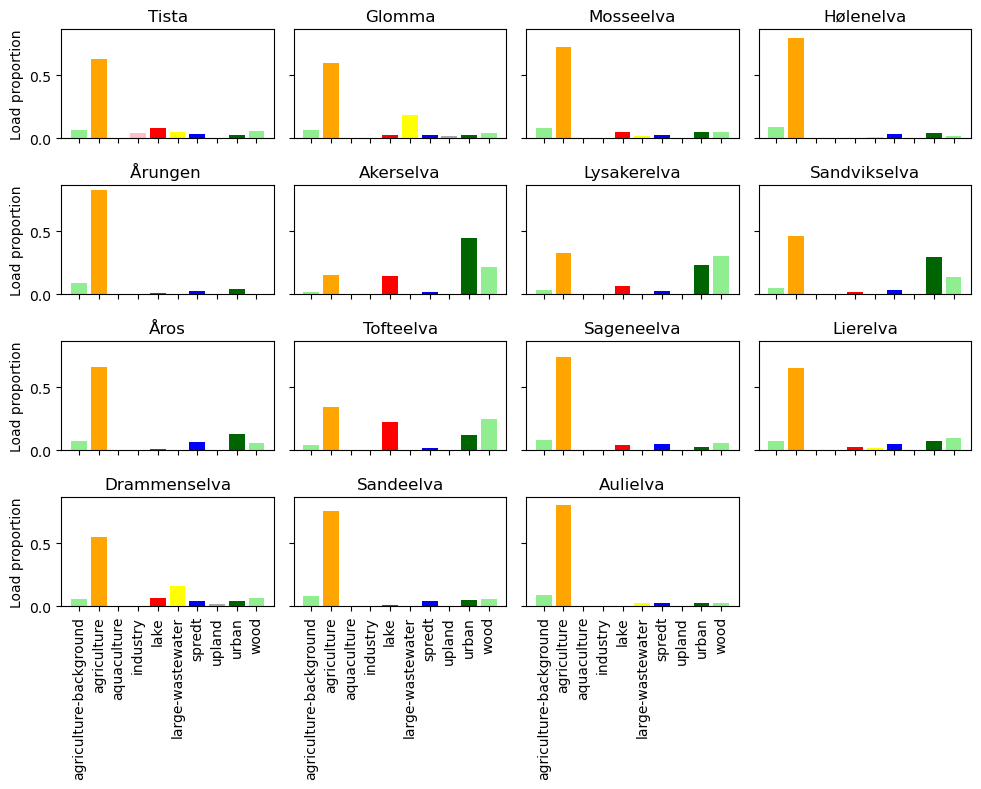

In [15]:
# # If aquaculture is always 0, drop
# if f_sector_df['aquaculture'].sum() == 0:
#     plot_df = f_sector_df.drop('aquaculture', axis=1)
# else:
#     plot_df = f_sector_df

plot_df = f_sector_df

num_columns = 4
num_rows = int(np.ceil(len(f_sector_df) / num_columns))

fig, axes = plt.subplots(num_rows, num_columns, sharex=True, sharey=True, figsize=(10, 8))
axes = axes.flatten()

# colors = ['light green', 'orange', 'gray', 'pink', 'red', 'yellow', 'blue', 'dark gray', 'dark green']
# colours translated to something that should plot
colors = ['#90ee90', '#ffa500', '#808080', '#ffc0cb', '#ff0000', '#ffff00', '#0000ff', '#a9a9a9', '#006400']
# Purple: '#800080'

for i, (num, row) in enumerate(plot_df.iterrows()):
    name = river_meta_df.loc[num, 'river_name']
    axes[i].bar(row.index, row.values, color=colors)
    axes[i].set_title(f"{name}")
    axes[i].tick_params(axis='x', rotation=90)
    if i % num_columns == 0:
        axes[i].set_ylabel('Load proportion')
    # axes[i].set_ylabel('Load proportion')

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
fpath = os.path.join(fig_folder, f"teotil_proportion_sector_inputs_{teotil_end_point}_{par}.png")
plt.savefig(fpath)
plt.show()

**Comments:**
- Agriculture dominates in most rivers
- Only Glomma, Drammenselva and Tista have noticeable sewage inputs
- Urban inputs are substantial in the Oslo city rivers (Akerselva, Lysakerelva, Sandvikselva)

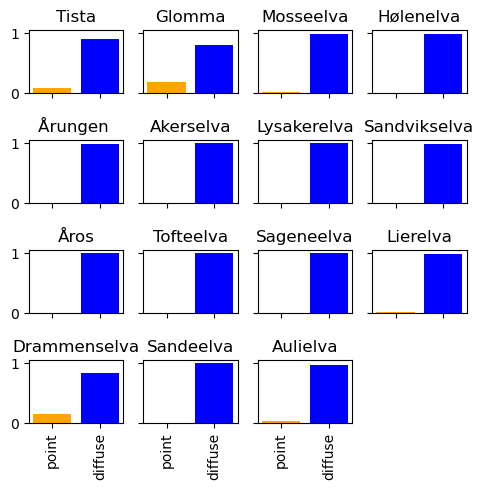

In [16]:
# Plot of point vs diffuse

plot_df = f_groupsector_df[['point', 'diffuse']]
num_columns = 4
num_rows = int(np.ceil(len(f_sector_df) / num_columns))

fig, axes = plt.subplots(num_rows, num_columns, sharex=True, sharey=True, figsize=(5, 5))
axes = axes.flatten()

# colours translated to something that should plot
colors = ['#ffa500', '#0000ff']

for i, (num, row) in enumerate(plot_df.iterrows()):
    name = river_meta_df.loc[num, 'river_name']
    axes[i].bar(row.index, row.values, color=colors)
    axes[i].set_title(f"{name}")
    axes[i].tick_params(axis='x', rotation=90)

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
fpath = os.path.join(fig_folder, f"teotil_proportion_pt-diffuse_{teotil_end_point}_{par}.png")
plt.savefig(fpath)
plt.show()

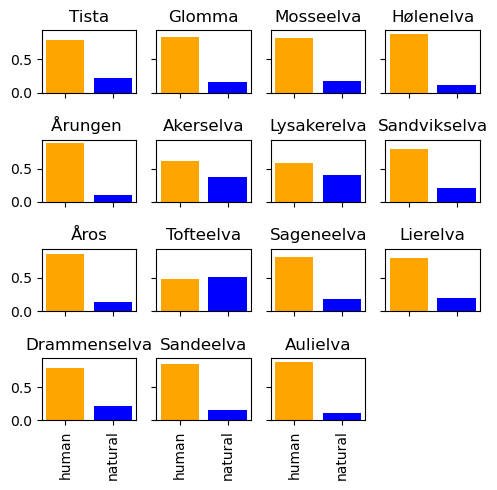

In [17]:
# Plot of human vs natural

plot_df = f_groupsector_df[['human', 'natural']]
num_columns = 4
num_rows = int(np.ceil(len(f_sector_df) / num_columns))

fig, axes = plt.subplots(num_rows, num_columns, sharex=True, sharey=True, figsize=(5, 5))
axes = axes.flatten()

# colours translated to something that should plot
colors = ['#ffa500', '#0000ff']

for i, (num, row) in enumerate(plot_df.iterrows()):
    name = river_meta_df.loc[num, 'river_name']
    axes[i].bar(row.index, row.values, color=colors)
    axes[i].set_title(f"{name}")
    axes[i].tick_params(axis='x', rotation=90)

# Remove any unused subplots
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
fpath = os.path.join(fig_folder, f"teotil_proportion_human-natural_{teotil_end_point}_{par}.png")
plt.savefig(fpath)
plt.show()

Akerselva, Lysakerelva, Tofteelva are the most 'natural' (i.e. human/natural inputs is smaller). The rest are very human-influenced.

## Compare loads for whole vassdragsområde vs main river

**To do**
- Read in Phil's direct point inputs. Need to know how to allocate them to vassdragsområder

In [18]:
teotil_vass_df = teotil_av_df_dict['Vassom'].copy()
teotil_vass_df['total'] = teotil_vass_df.sum(axis=1)

teotil_riv_df = teotil_av_df_dict['Regine'].copy()
teotil_riv_df['total'] = teotil_riv_df.sum(axis=1)

# For the rivers df, sum up rivers 15 and 16 (which are in the same vassdragsområde, 10)
# and remove 15, for compatibility with the vass_df
teotil_riv_df.loc[16] = teotil_riv_df.loc[[15, 16], :].sum()
teotil_riv_df.drop(15, axis=0, inplace=True)

# Area-scale the river inputs up to the whole vassdragsområde area

# Calculate area scaling factor
river_meta_df['reg_area_scaling_f'] = river_meta_df['Vassom_area_land'] / river_meta_df['reg_upstr_area_km2']

# Align the two DataFrames on their index
aligned_teotil_riv_df, aligned_river_meta_df = teotil_riv_df.align(river_meta_df['reg_area_scaling_f'], axis=0)

# Scale
teotil_scaled_riv_df = aligned_teotil_riv_df.multiply(aligned_river_meta_df, axis=0)
# Don't area-scale industry or large wastewater?? Rationale being they are directly discharged to the fjord
for source in ['industry', 'large-wastewater']:
    teotil_scaled_riv_df[source] = aligned_teotil_riv_df[source]

# Difference bewteen area-scaled river inputs and whole vassområde inputs?
diff_df = teotil_scaled_riv_df - teotil_vass_df
percent_diff_df = 100 * diff_df / teotil_vass_df
percent_diff_df.fillna(0, inplace=True)

**Quick look at output**

In [19]:
# Area-scaling factors
river_meta_df['reg_area_scaling_f'].head()

real_river
6     1.575624
7     1.012104
8     1.231559
9     1.467415
10    5.398111
Name: reg_area_scaling_f, dtype: float64

In [20]:
# Inputs for the whole vassdragsområde
teotil_vass_df.round(1)

,agriculture-background,agriculture,aquaculture,industry,lake,large-wastewater,spredt,upland,urban,wood,total
real_river,,,,,,,,,,,
6,41790.3,376112.6,0.0,16870.2,35271.4,111618.1,16684.0,1581.9,15280.8,28895.0,644104.4
7,699589.9,6296308.7,0.0,43644.8,288879.0,1834737.2,299167.1,203140.7,305811.8,450888.6,10422167.7
8,42511.1,382599.5,0.0,0.0,12080.9,210441.1,10297.3,371.1,27834.9,14195.7,700331.6
9,21537.7,193839.7,11.1,0.0,130.4,124331.7,10038.2,80.3,13623.0,4935.6,368527.6
10,12172.1,109549.1,0.0,0.0,2256.6,66852.1,12240.9,64.4,19691.9,5814.2,228641.3
11,1055.7,9501.6,0.0,0.0,6314.0,355934.8,941.0,184.6,65979.5,10669.2,450580.3
12,1421.1,12789.7,0.0,0.0,2295.8,13.2,1002.3,171.4,23672.2,11225.9,52591.6
13,5538.3,49844.4,0.0,0.2,1321.6,379.1,3334.9,226.7,44511.4,11476.2,116632.7
14,6587.5,59287.6,0.0,6419.0,1667.6,959500.8,5764.5,49.7,22762.1,6752.6,1068791.4


In [21]:
# Inputs just for the main river per vassdragsområde
teotil_riv_df.round(1)

,agriculture-background,agriculture,aquaculture,industry,lake,large-wastewater,spredt,upland,urban,wood,total
real_river,,,,,,,,,,,
6,25374.9,228373.9,0.0,16870.2,30568.0,17923.6,11663.9,1088.0,9308.6,20349.5,361520.6
7,661296.8,5951671.3,0.0,43644.8,287181.4,1834438.5,290581.6,201736.6,280702.5,440928.4,9992182.0
8,18712.3,168410.5,0.0,0.0,12027.8,4176.3,6391.1,221.4,10935.5,11123.1,231997.9
9,14447.0,130022.8,0.0,0.0,102.3,2342.7,6044.0,50.7,7189.9,3367.9,163567.2
10,5473.1,49257.8,0.0,0.0,463.4,328.7,1477.0,7.6,2333.5,409.7,59750.9
11,639.0,5750.8,0.0,0.0,5423.5,19.4,602.0,87.4,16834.6,8098.0,37454.7
12,1282.5,11542.6,0.0,0.0,2271.2,13.2,908.1,157.3,8320.9,10686.9,35182.7
13,3867.6,34808.5,0.0,0.2,1225.2,379.1,2428.2,174.6,22628.2,10250.0,75761.5
14,4617.7,41559.3,0.0,0.0,786.5,0.0,4126.1,26.7,8301.7,3672.3,63090.1


In [22]:
# Area-scaled inputs for the main river
teotil_scaled_riv_df.head().round(1)

,agriculture-background,agriculture,aquaculture,industry,lake,large-wastewater,spredt,upland,urban,wood,total
real_river,,,,,,,,,,,
6,39981.3,359831.4,0.0,16870.2,48163.6,17923.6,18377.9,1714.3,14666.8,32063.2,569620.4
7,669301.1,6023710.1,0.0,43644.8,290657.5,1834438.5,294098.8,204178.4,284100.1,446265.4,10113126.9
8,23045.3,207407.5,0.0,0.0,14812.9,4176.3,7871.0,272.6,13467.7,13698.8,285719.2
9,21199.7,190797.3,0.0,0.0,150.1,2342.7,8869.1,74.4,10550.6,4942.0,240020.9
10,29544.3,265899.0,0.0,0.0,2501.7,328.7,7972.9,41.2,12596.6,2211.5,322541.8


In [23]:
# Area-scaled inputs minus vassdragsområde inputs
diff_df.round(1)

,agriculture-background,agriculture,aquaculture,industry,lake,large-wastewater,spredt,upland,urban,wood,total
real_river,,,,,,,,,,,
6,-1809.0,-16281.3,0.0,0.0,12892.2,-93694.5,1693.8,132.5,-614.0,3168.2,-74484.0
7,-30288.7,-272598.7,0.0,0.0,1778.5,-298.7,-5068.3,1037.7,-21711.7,-4623.1,-309040.9
8,-19465.8,-175192.0,0.0,0.0,2732.0,-206264.8,-2426.3,-98.4,-14367.2,-497.0,-414612.4
9,-338.0,-3042.3,-11.1,0.0,19.7,-121989.0,-1169.1,-5.9,-3072.4,6.5,-128506.7
10,17372.2,156349.9,0.0,0.0,245.1,-66523.4,-4268.0,-23.2,-7095.3,-3602.7,93900.5
11,-2.0,-17.7,0.0,0.0,2630.1,-355915.5,51.8,-40.5,-38216.9,2685.6,-388812.4
12,45.6,410.7,0.0,0.0,301.7,0.0,36.3,8.5,-14156.1,996.0,-12355.5
13,-760.7,-6846.2,0.0,0.0,191.8,0.0,-335.4,-11.1,-16559.3,1185.4,-23046.2
14,2137.4,19236.4,0.0,-6419.0,-181.6,-959500.8,2031.5,0.6,-7076.5,185.9,-949586.0


In [24]:
# Percent difference
percent_diff_df.round(1)

,agriculture-background,agriculture,aquaculture,industry,lake,large-wastewater,spredt,upland,urban,wood,total
real_river,,,,,,,,,,,
6,-4.3,-4.3,0.0,0.0,36.6,-83.9,10.2,8.4,-4.0,11.0,-11.6
7,-4.3,-4.3,0.0,0.0,0.6,-0.0,-1.7,0.5,-7.1,-1.0,-3.0
8,-45.8,-45.8,0.0,0.0,22.6,-98.0,-23.6,-26.5,-51.6,-3.5,-59.2
9,-1.6,-1.6,-100.0,0.0,15.1,-98.1,-11.6,-7.4,-22.6,0.1,-34.9
10,142.7,142.7,0.0,0.0,10.9,-99.5,-34.9,-36.0,-36.0,-62.0,41.1
11,-0.2,-0.2,0.0,0.0,41.7,-100.0,5.5,-21.9,-57.9,25.2,-86.3
12,3.2,3.2,0.0,0.0,13.1,0.0,3.6,4.9,-59.8,8.9,-23.5
13,-13.7,-13.7,0.0,0.0,14.5,0.0,-10.1,-4.9,-37.2,10.3,-19.8
14,32.4,32.4,0.0,-100.0,-10.9,-100.0,35.2,1.3,-31.1,2.8,-88.8


**Comments:**
Negative values in the above mean that if we assume the same catchment characteristics in the whole vassdragsområde as in our main river, we end up underestimating inputs. So a negative total means an overall underestimate.

* Some notable exceptions, but agriculture is generally underestimated. i.e. implies the whole vassdragsområde has more agriculture than the main river catchment. Not so much the case for the big rivers (7 & 18)
* Direct lake inputs are overestimated. Whole vassdragsområde has fewer lake area than the main river catchment
* Spredt is pretty mixed, generally a bit more underestimated than over
* Upland: mixed over or under-estimation
* Urban: uniformly negative, i.e. underestimated. Whole vassdragsområde has more urban land than the main river. Expected.
* Woodland: usually positive, i.e. overestimating inputs. i.e. whole vassdragsområde is less wooded than the main river catchment

Next steps:
- Assume differences in industrial and wwtw loads are direct discharges to the fjord, taken into account in the OF800 iSource file. Does the difference in load match the direct OF800 WWTW inputs?
- Need to remove industry and large wastewater from totals (assuming that's taken care of with the direct inputs file). Can then look at overal under/over-estimates.

**To look at in more detail:**

Industry inputs present in vassdragsområde but not upstream of main regine:

real riv 14: 6419 kg DIN, 0 iregine
r
real riv 16: 582 kg DIN, 0 regine
ne
real riv 19: 37540 kg DIN, 0regine
ine

wwtw inputs the same in vassdragsområde and r - rly in  very similar - iver 7
12, 13

# Read in daily river data netcdf & tidy

In [25]:
ds = xr.open_dataset(fpath_baseline_data)

# Select just the variables of interest
ds = ds[riv_var_li_dict[species]]
ds

<xarray.Dataset>
Dimensions:          (river_time: 12053, real_river: 39)
Coordinates:
  * real_river       (real_river) float64 1.0 2.0 3.0 4.0 ... 37.0 38.0 39.0
  * river_time       (river_time) datetime64[ns] 1990-01-01T12:00:00 ... 2022...
Data variables:
    river_NH4N       (river_time, real_river) float32 ...
    river_NO3NO2N    (river_time, real_river) float32 ...
    river_TOTN       (river_time, real_river) float32 ...
    river_DON        (river_time, real_river) float32 ...
    river_PON        (river_time, real_river) float32 ...
    river_transport  (river_time, real_river) float32 ...
Attributes:
    river_main_station_names_1-10:   1=Göta älv, Alelyckan; 2=Bäveån Uddevall...
    river_main_station_names_11-20:  11=Akerselva, hovedmålestasjon; 12=Lysak...
    river_main_station_names_21-30:  21=Numedalslågen ved Bommestad (E18); 22...
    river_main_station_names_31-39:  31=Kvina; 32=Klostergrøften, Klostergrøf...
    history:                         Thu Mar 21 17:07:47 2024: ncks -4 -L 5 m...
    NCO:                             4.7.2

In [26]:
# Convert to dataframe
# N.B. loose units info then. m3/s for Q, ug/l for rest
conc_df = ds.to_dataframe()
ds.close()

conc_df = conc_df.reset_index()  # Drop multiindex

# # Add river name to df
# conc_df['river_name'] = conc_df['real_river'].map(river_meta_df['river_name'])

# Select just the Oslofjord rivers
conc_df = conc_df[conc_df['real_river'].isin(oslofjord_riv_nos)]

# Calculate DIN and TON
conc_df['din'] = conc_df['river_NH4N'] + conc_df['river_NO3NO2N']
# Assume particulate organic N = 0, and that this is more robust than TON = PON+DON
conc_df['ton'] = conc_df['river_TOTN'] - conc_df['din']

# Convert all numeric columns to float64 (chem cols were float32)
conc_df[riv_var_li] = conc_df[riv_var_li].astype(float)

# Round concentrations to 3 d.p. (N.B. only appropriate for ug/l)
conc_df[chem_var_li] = conc_df[chem_var_li].round(3)

# Truncate to start and end date
conc_df = conc_df.query('@start_date <= river_time <= @end_date')

conc_df.tail()

,river_time,real_river,river_NH4N,river_NO3NO2N,river_TOTN,river_DON,river_PON,river_transport,din,ton
470043,2022-12-31 12:00:00,16.0,9.192,1210.840,1338.208,101.914,16.116,0.731608,1220.031982,118.176003
470044,2022-12-31 12:00:00,17.0,39.270,866.487,1393.936,471.387,16.640,19.877710,905.757019,488.178986
470045,2022-12-31 12:00:00,18.0,13.546,342.997,508.703,135.739,16.272,258.239807,356.544006,152.158997
470046,2022-12-31 12:00:00,19.0,19.452,113.672,378.166,232.165,12.761,16.971445,133.123993,245.042007
470047,2022-12-31 12:00:00,20.0,274.545,1641.914,2143.350,209.739,16.999,39.055298,1916.458008,226.891998


In [27]:
# Explore for specific rivers/times
temp = conc_df.loc[conc_df['real_river'] == 14, ['river_time', 'river_NO3NO2N', 'river_transport']]

# Calculate daily & annual loads from the river data

## Daily loads

In [28]:
# Daily loads

# Make empty dataframe with just time & location info
daily_load_df = conc_df.drop(chem_var_li+['river_transport'], axis=1)

# Calculate load
for var in chem_var_li:
    # Units ug/l * m3/s * l/m3 * kg/ug * s/d = kg/d
    daily_load_df[var] = conc_df[var] * conc_df['river_transport'] * 10**3 * 10**-9 * 86400

chem_cols = daily_load_df.columns.drop(['river_time', 'real_river'])

daily_load_df.head()

,river_time,real_river,river_NH4N,river_NO3NO2N,river_TOTN,river_DON,river_PON,din,ton
327644,2013-01-01 12:00:00,6.0,99.304292,4136.529999,7003.108914,2526.572795,238.531498,4235.834311,2767.274610
327645,2013-01-01 12:00:00,7.0,692.954032,10022.521099,15417.079198,3971.521497,723.502474,10715.475200,4701.604138
327646,2013-01-01 12:00:00,8.0,199.130873,1214.673897,2189.321439,725.723523,49.342304,1413.806793,775.514680
327647,2013-01-01 12:00:00,9.0,68.907812,444.080250,735.532002,213.324874,9.136322,512.988079,222.544318
327648,2013-01-01 12:00:00,10.0,48.569385,674.590934,1159.604665,427.357783,9.005329,723.159846,436.444786


In [29]:
# # What % of TON is PON?
# # daily_load_df.plot(kind='scatter', x='river_DON', y='river_PON')
# ratio = 100 * daily_load_df['river_PON']/daily_load_df['ton']
# ratio.describe()

## Annual loads

In [30]:
# Annual loads (kg/year)
annual_load_df = daily_load_df.copy().set_index('river_time')
annual_load_df = annual_load_df.groupby('real_river').resample('A').sum()

# Tidy
annual_load_df.drop('real_river', axis=1, inplace=True)
annual_load_df.reset_index(inplace=True)

# # Convert to tonnes (10**3 kg) per year
# annual_load_df[chem_cols] = annual_load_df[chem_cols]/1000

annual_load_df['year'] = annual_load_df['river_time'].dt.year
annual_load_df.drop('river_time', axis=1, inplace=True)

annual_load_df

,real_river,river_NH4N,river_NO3NO2N,river_TOTN,river_DON,river_PON,din,ton,year
0,6.0,12148.756964,4.696627e+05,8.548883e+05,348684.806476,24172.481743,4.818115e+05,373076.835932,2013
1,6.0,24691.520987,7.179538e+05,1.250792e+06,475092.293767,32759.244722,7.426454e+05,508146.259677,2014
2,6.0,12583.748320,6.601110e+05,1.144701e+06,440762.570758,30962.687071,6.726948e+05,472006.466481,2015
3,6.0,4797.933241,4.289918e+05,7.312321e+05,278736.468703,18537.616741,4.337896e+05,297442.459635,2016
4,6.0,13040.528094,5.503839e+05,9.138086e+05,329938.122509,20261.996188,5.634244e+05,350384.186715,2017
...,...,...,...,...,...,...,...,...,...
145,20.0,38339.002290,1.462085e+06,1.740374e+06,232419.643202,7462.601503,1.500424e+06,239950.040393,2018
146,20.0,91712.170890,1.822525e+06,2.073845e+06,143126.576566,16366.050079,1.914237e+06,159607.813147,2019
147,20.0,57215.250183,1.446076e+06,1.696930e+06,179414.366692,14098.026588,1.503292e+06,193638.226411,2020
148,20.0,84678.923005,1.018992e+06,1.320784e+06,208575.738556,8460.393411,1.103671e+06,217112.974208,2021


# Split river data annual loads by sector
Using proportions from TEOTIL averaged over the period 2013-2022 (at the moment)

In [31]:
# Just get annual loads for TEOTIL variable. Current one is din
annual_load_df_var = annual_load_df[['real_river', 'year', par]]
annual_load_df_var.set_index('real_river', inplace=True)

merged_df = annual_load_df_var.join(f_sector_df_dict['Regine'], how='left')
# Drop any Swedish rivers not present in TEOTIL
merged_df.dropna(how='any', inplace=True)

annual_sector_df = pd.DataFrame(index=merged_df.index)
annual_sector_df['year'] = merged_df['year']

for sector in f_sector_df_dict['Regine'].columns:
    annual_sector_df[sector] = merged_df[par] * merged_df[sector]

annual_sector_df.reset_index(inplace=True)

# Drop years outside the model data range
annual_sector_df = annual_sector_df.query('@start_year <= year <= @end_year')

annual_sector_df

,real_river,year,agriculture-background,agriculture,aquaculture,industry,lake,large-wastewater,spredt,upland,urban,wood
0,6.0,2013,33818.013412,3.043621e+05,0.0,22483.520377,40739.021478,23887.437691,15544.867313,1450.068900,12405.845761,27120.559836
1,6.0,2014,52125.768578,4.691319e+05,0.0,34655.222520,62793.540820,36819.165982,23960.252965,2235.079718,19121.887417,41802.574518
2,6.0,2015,47215.980962,4.249438e+05,0.0,31391.006241,56878.943156,33351.125316,21703.408481,2024.554924,17320.774290,37865.140725
3,6.0,2016,30447.395468,2.740266e+05,0.0,20242.603493,36678.591459,21506.593342,13995.521168,1305.541538,11169.363717,24417.472445
4,6.0,2017,39546.372598,3.559174e+05,0.0,26291.954625,47639.715054,27933.678416,18177.978323,1695.692893,14507.244789,31714.452037
...,...,...,...,...,...,...,...,...,...,...,...,...
145,20.0,2018,133929.637046,1.205367e+06,0.0,0.000000,4189.378183,44455.826966,38571.341184,392.799409,39254.376969,34263.934114
146,20.0,2019,170867.064783,1.537804e+06,0.0,0.000000,5344.797232,56716.622501,49209.211630,501.132412,50080.626816,43713.833466
147,20.0,2020,134185.603063,1.207670e+06,0.0,0.000000,4197.384913,44540.790840,38645.058644,393.550126,39329.399844,34329.419266
148,20.0,2021,98514.955789,8.866346e+05,0.0,0.000000,3081.591316,32700.483065,28372.017242,288.932437,28874.439570,25203.607124


In [32]:
# Sum up to estimate point, diffuse, human sums
annual_groupsector_df = annual_sector_df[['real_river', 'year']].copy()
annual_groupsector_df['point'] = annual_sector_df[point_source_li].sum(axis=1)
annual_groupsector_df['diffuse'] = annual_sector_df[diffuse_source_li].sum(axis=1)
annual_groupsector_df['human'] = annual_sector_df[human_source_li].sum(axis=1)
annual_groupsector_df['natural'] = annual_sector_df[natural_source_li].sum(axis=1)
annual_groupsector_df['total'] = annual_groupsector_df['point'] + annual_groupsector_df['diffuse']

annual_groupsector_df

,real_river,year,point,diffuse,human,natural,total
0,6.0,2013,46370.958068,4.354405e+05,3.786838e+05,103127.663626,4.818115e+05
1,6.0,2014,71474.388502,6.711710e+05,5.836884e+05,158956.963633,7.426454e+05
2,6.0,2015,64742.131557,6.079526e+05,5.287101e+05,143984.619767,6.726948e+05
3,6.0,2016,41749.196835,3.920404e+05,3.409406e+05,92849.000910,4.337896e+05
4,6.0,2017,54225.633041,5.091988e+05,4.428282e+05,120596.232581,5.634244e+05
...,...,...,...,...,...,...,...
145,20.0,2018,44455.826966,1.455968e+06,1.327648e+06,172775.748752,1.500424e+06
146,20.0,2019,56716.622501,1.857520e+06,1.693810e+06,220426.827892,1.914237e+06
147,20.0,2020,44540.790840,1.458751e+06,1.330186e+06,173105.957368,1.503292e+06
148,20.0,2021,32700.483065,1.070970e+06,9.765815e+05,127089.086665,1.103671e+06


# Estimate daily loads from point sources vs diffuse sources
Key assumptions: constant daily load from point sources, irrespective of discharge; input from diffuse sources increases with discharge in an undefined way. So first estimate point source contribution to load, then estimate diffuse input by difference:
- Total daily load (already calculated above), L_tot =C_t Q_t
- Daily load from point sources, L(pt,daily) = L_pt,whole-period / number of days in the model period
- Daily load from diffuse sources, L(diffuse, daily) = L(tot, daily) - L(pt, daily)
- Plots to check looks sensible. What to do with negative values?e


In [33]:
# Estimate point sources as a constant daily input over the whole period

# Sum up over the whole model period (start of start year to end of end year)
annual_point_df_sum = annual_groupsector_df[['real_river', 'year', 'point']].groupby('real_river').sum()
annual_point_df_sum.drop('year', axis=1, inplace=True)

# Divide by the number of days in the whole model period
tot_days =  end_date - start_date
tot_days = tot_days.days

daily_point_df = annual_point_df_sum / tot_days
daily_point_df.head()

,point
real_river,
6.0,179.041432
7.0,4298.477239
8.0,16.850147
9.0,7.734803
10.0,2.259376


In [34]:
# # Estimate point sources as a constant daily input per year

# daily_point_df = annual_groupsector_df[['real_river', 'year']].copy()
# daily_point_df['point'] = annual_groupsector_df['point'] / 365

# # Convert 'year' to datetime, add a row at the start for interpolation of the full time period
# daily_point_df['year'] = pd.to_datetime(daily_point_df['year'], format='%Y') + pd.offsets.YearEnd(1)
# first_row = daily_point_df.iloc[0].copy()
# first_row['year'] = datetime.datetime(first_row['year'].year, 1, 1)
# daily_point_df = pd.concat([pd.DataFrame(first_row).T, daily_point_df], ignore_index=True).reset_index(drop=True)
# daily_point_df.rename(columns={'year':'date'}, inplace=True)

# daily_point_df.set_index(['real_river', 'date'], inplace=True)

# # Resample to daily frequency & interpolate
# daily_point_df = daily_point_df.groupby(level=0).resample('D', level=1).mean()
# daily_point_df['point'] = daily_point_df.groupby(level=0, group_keys=False)['point'].apply(lambda group: group.interpolate())

# # # Reset index
# # # daily_point_df.reset_index(inplace=True)

# daily_point_df

In [35]:
# Get daily load data for just the TEOTIL chemical variable of interest
daily_load_df_var = daily_load_df[['real_river', 'river_time', par]].copy()

# Reformat & rename columns
daily_load_df_var.columns = ['real_river', 'date', 'total']
# Drop 12:00 time info from the dates, for compatibility with other dfs
daily_load_df_var['date'] = daily_load_df_var['date'].dt.normalize()
daily_load_df_var.set_index(['real_river', 'date'], inplace=True)
# print(daily_load_df_var.head())

# Join the daily load df with the estimated daily point inputs
calc_load_df = daily_load_df_var.join(daily_point_df, on='real_river', how='outer')

# Estimate diffuse inputs by subtracting point from total
calc_load_df['diffuse_raw'] = calc_load_df['total'] - calc_load_df['point']

calc_load_df

total       point  diffuse_raw
real_river date                                            
6.0        2013-01-01  4235.834311  179.041432  4056.792879
           2013-01-02  3918.087439  179.041432  3739.046007
           2013-01-03  1991.311006  179.041432  1812.269574
           2013-01-04  1963.764012  179.041432  1784.722580
           2013-01-05  1890.143944  179.041432  1711.102512
...                            ...         ...          ...
20.0       2022-12-27  6312.893951   98.408537  6214.485414
           2022-12-28  6352.336934   98.408537  6253.928397
           2022-12-29  6391.311161   98.408537  6292.902625
           2022-12-30  6429.546008   98.408537  6331.137471
           2022-12-31  6466.853230   98.408537  6368.444694

[54780 rows x 3 columns]

## Plot uncorrected

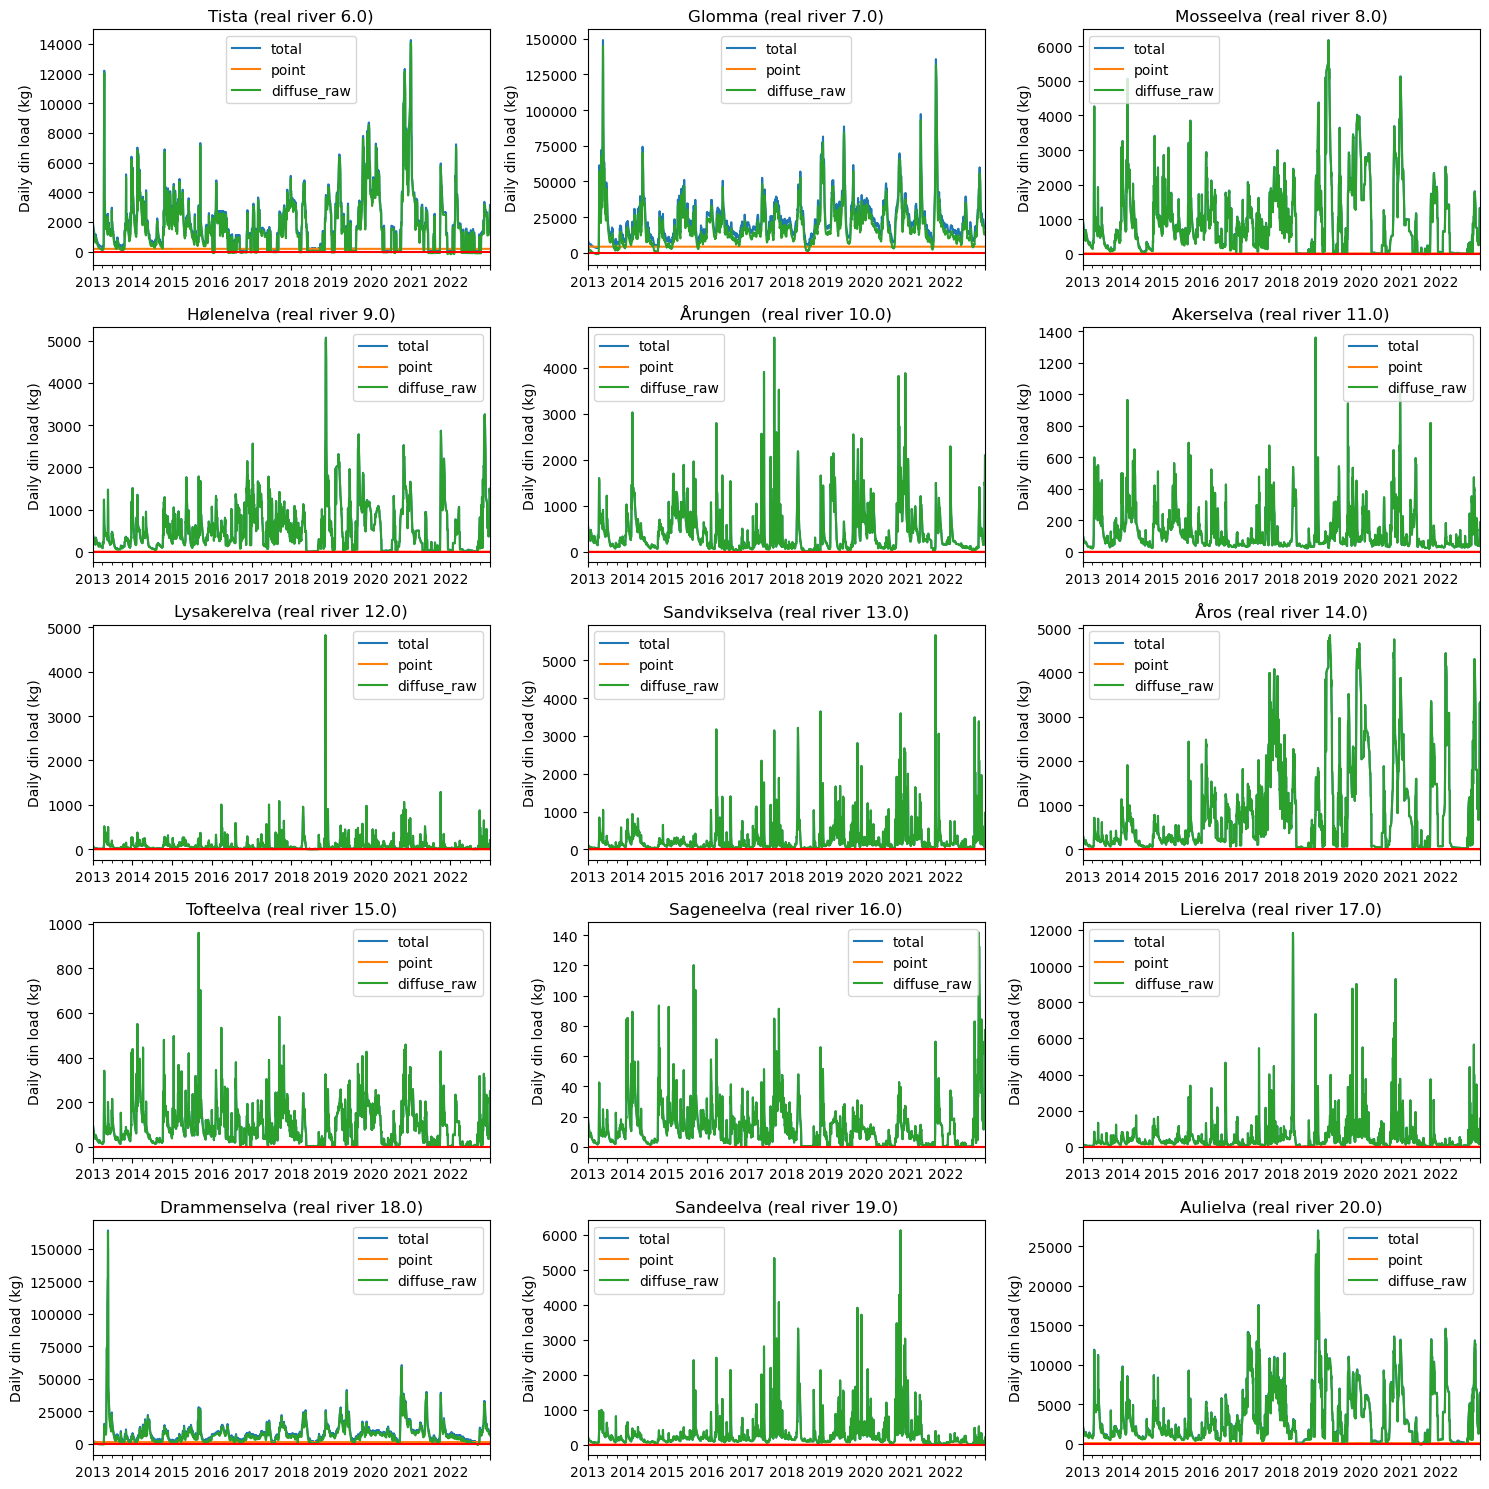

In [36]:
real_rivers = calc_load_df.index.get_level_values('real_river').unique()

n_rows = int(np.ceil(len(real_rivers) / 3))
fig, axs = plt.subplots(n_rows, 3, figsize=(15, n_rows*3))
axs = axs.flatten()

# For each real_river
for i, real_river in enumerate(real_rivers):
    name = river_meta_df.loc[real_river, 'river_name']
    df = calc_load_df.loc[real_river]
    df.plot(ax=axs[i])
    axs[i].axhline(0, color='r')
    axs[i].set_xlabel('')
    axs[i].set_ylabel(r'Daily %s load (kg)' % par)
    axs[i].set_title(f'{name} (real river {real_river})')
    axs[i].legend()

plt.tight_layout()
plt.show()

**Comments**

**This is extremely influenced by the choice of whether to summarise TEOTIL inputs over the whole vassdragsområde or just the downstream regine associated with the main river**. The whole vassdragsområde includes point source inputs directly to the sea (e.g. VEAS), so of course this approach won't work for the whole vassdragsområde, unless these direct land-sea fluxes are first subtracted from the TEOTIL point sources. Perhaps something to look into for the future. For now, just go with the downstream REGINE as the TEOTIL unit.

Then, point source inputs are minor. The river with the highest point source inputs is in fact Glomma, at 20%. The approach works well everywhere including there, i.e. after subtracting daily point inputs during low flows, we're not going particularly negative.

There are however small negative values that need to be removed. These are small, so it's not worth fiddling too much... Approach: sum up the absolute of the negative over the whole period, divide by the days in the period, and then subtract from the diffuse load for days where this is > total-point

## Redistribute negative mass

In [37]:
def remove_negatives(row):
    if row['point'] > row['total']:
        row['leftover'] = row['point'] - row['total']
        row['point'] = row['total']
        row['diffuse'] = 0
    else:
        row['point'] = row['point']
        row['diffuse'] = row['diffuse']
        row['leftover'] = 0
    return row

def redistribute_leftover(df):
    leftover_mass = df['leftover'].sum()
    n_days = len(df[df['diffuse'] > 0])
    mask = df['diffuse'] > 0
    df.loc[mask, 'point'] = df.loc[mask, 'point'] + leftover_mass / n_days
    df.loc[mask, 'diffuse'] = df.loc[mask, 'total'] - df.loc[mask, 'point']
    df['leftover'] = 0
    return df


In [38]:
# # Test case for developing
# df = pd.DataFrame({'total': [12, 10, 30, 5], 'point_raw': [10, 10, 10, 10]}, index=[1,2,3,4])
# df['diffuse_raw'] = df['total'] - df['point_raw']

# # Set up for looping
# df['leftover'] = 0
# df['diffuse'] = df['diffuse_raw']
# df['point'] = df['point_raw']

# # First iteration
# print('Start')
# print(df)

# counter=0
# max_iterations = 20
# while len(df.loc[df['diffuse'] < 0]) > 0:
#     print('iteration %s' % counter)
#     if counter >= max_iterations:
#         print(f"Maximum number of iterations reached: {max_iterations}")
#         break
#     df = df.apply(remove_negatives, axis=1)
#     df = redistribute_leftover(df)
#     print(df)
#     counter += 1

In [39]:
# Apply to real data
calc_load_df = daily_load_df_var.join(daily_point_df, on='real_river', how='outer')

riv_nos = calc_load_df.index.get_level_values(0).unique().tolist()

daily_load_dict = {}  # Do away with multi-indexing! Use a dict instead from now on
                      # Key: river number, returns df with datetime index, one col per source
                      # or combined sources

# Apply to real data
for riv_no in riv_nos:
    df = calc_load_df.loc[riv_no]

    df['diffuse_raw'] = df['total'] - df['point']
    df['diffuse'] = df['diffuse_raw']
    df['leftover'] = 0
    df['point_raw'] = df['point']

    # print(f'Start {riv_no}')
    # print(df.round(1))

    counter = 0
    max_iterations = 20
    while len(df.loc[df['diffuse'] < 0]) > 0:
        # print('iteration %s' % counter)
        if counter >= max_iterations:
            print(f"Maximum number of iterations reached: {max_iterations}")
            break
        df = df.apply(remove_negatives, axis=1)
        df = redistribute_leftover(df)
        counter += 1

    print(f"River {riv_no}: {counter} iterations to redistribute mass")

    # Check original point source inputs and final ones are equal
    if df['point_raw'].sum().round(1) != df['point'].sum().round(1):
        print("New point source doesn't add up")

    df = df[['total', 'diffuse', 'point']]
    daily_load_dict[riv_no] = df

River 6.0: 3 iterations to redistribute mass
River 7.0: 2 iterations to redistribute mass
River 8.0: 2 iterations to redistribute mass
River 9.0: 0 iterations to redistribute mass
River 10.0: 0 iterations to redistribute mass
River 11.0: 0 iterations to redistribute mass
River 12.0: 0 iterations to redistribute mass
River 13.0: 0 iterations to redistribute mass
River 14.0: 0 iterations to redistribute mass
River 15.0: 0 iterations to redistribute mass
River 16.0: 0 iterations to redistribute mass
River 17.0: 1 iterations to redistribute mass
River 18.0: 1 iterations to redistribute mass
River 19.0: 0 iterations to redistribute mass
River 20.0: 1 iterations to redistribute mass


## Plot result

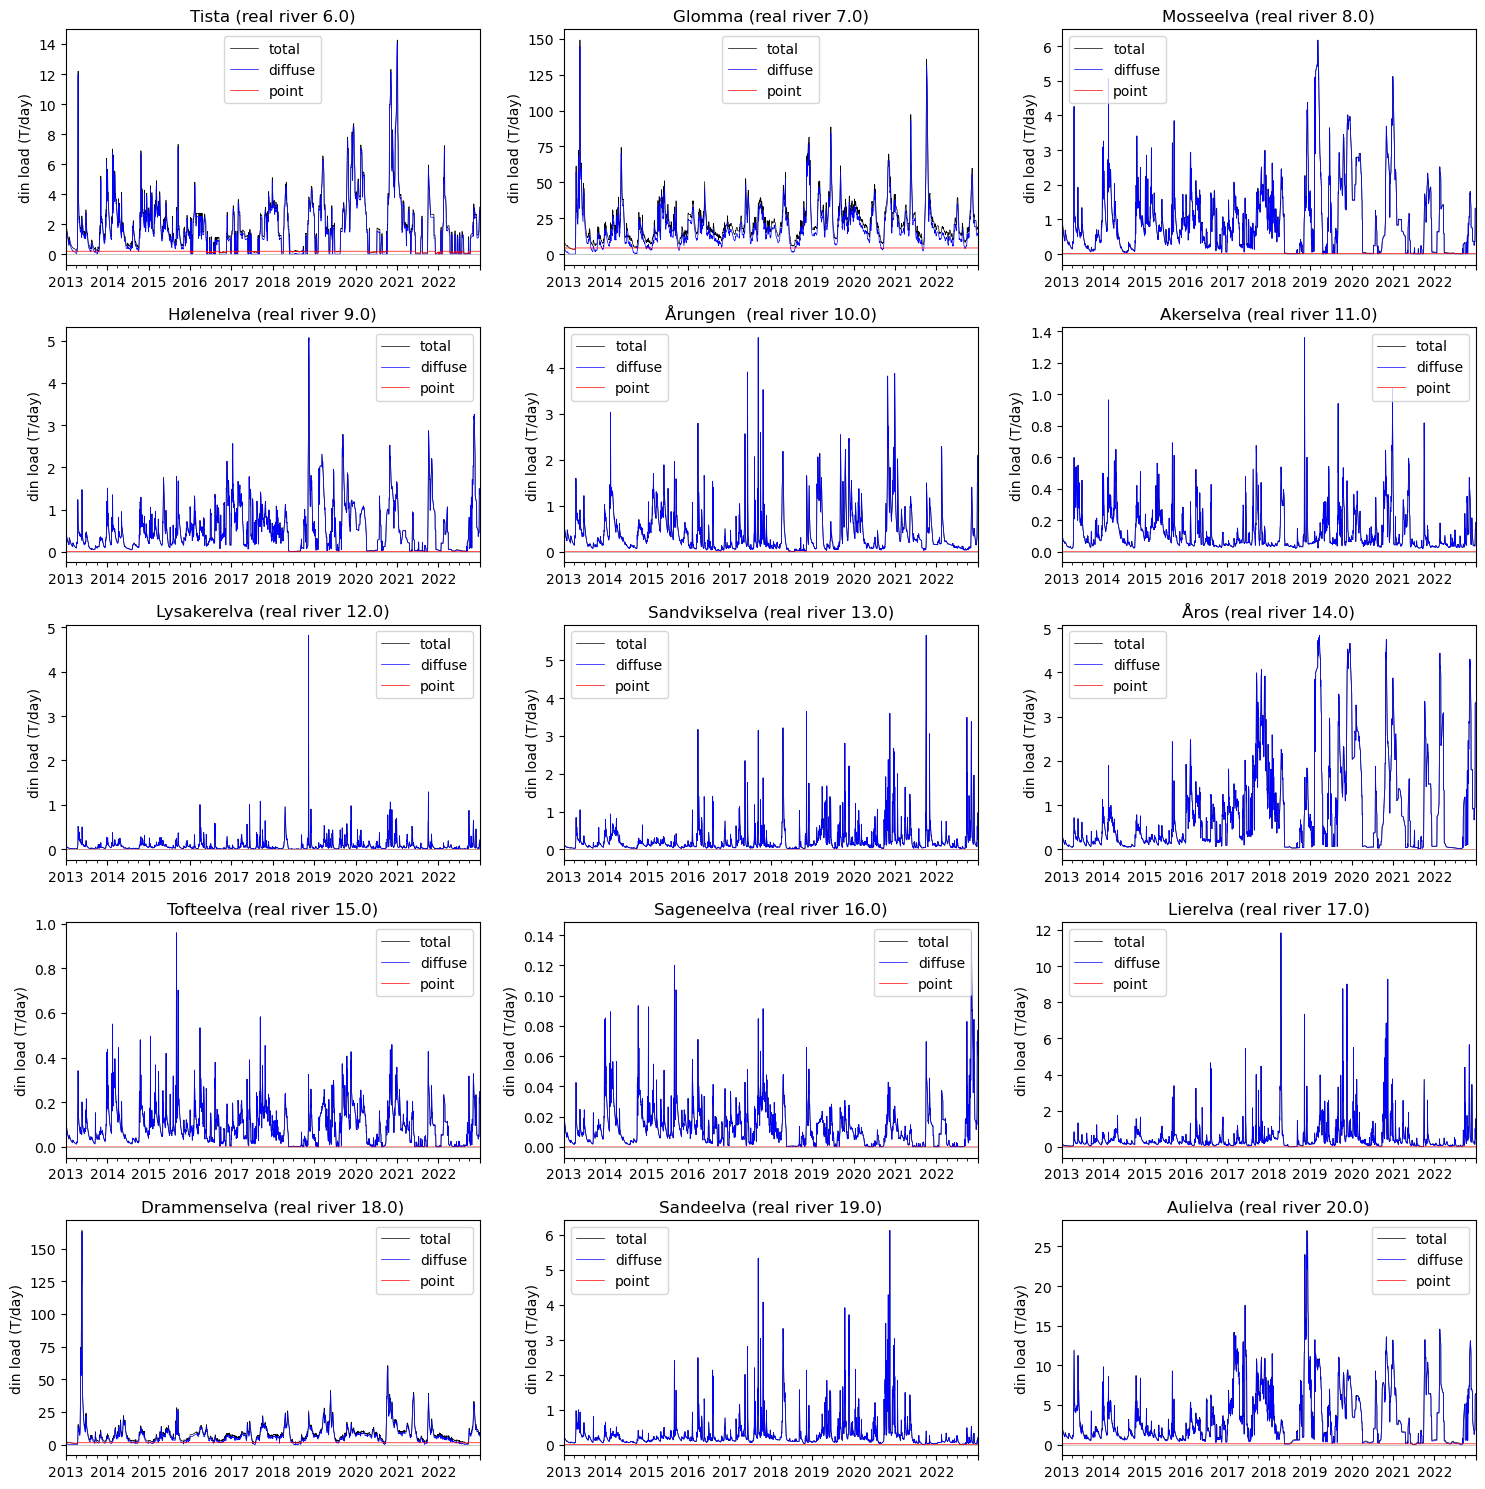

In [40]:
n_rows = int(np.ceil(len(real_rivers) / 3))
fig, axs = plt.subplots(n_rows, 3, figsize=(15, n_rows * 3))
axs = axs.flatten()
color_li = ["k", "b", "r"]

# For each real_river
for i, real_river in enumerate(real_rivers):
    name = river_meta_df.loc[real_river, "river_name"]
    df = daily_load_dict[real_river] / 1000
    df.plot(ax=axs[i], color=color_li, linewidth=0.5)
    axs[i].axhline(0, color="0.7", linewidth=0.5)
    axs[i].set_xlabel("")
    axs[i].set_ylabel(r"%s load (T/day)" % par)
    axs[i].set_title(f"{name} (real river {real_river})")
    axs[i].legend()

plt.tight_layout()
plt.show()

# Daily loads from all sectors

Do this based on:
1) The proportion of point source inputs which are large sewage vs industry
2) The proportion of diffuse source inputs which are agriculture, urban and spredt (the rest are "natural")

Then estimate daily loads as this proportion multiplied by the total daily load from point of diffuse sources.

In [41]:
f_sector_diffuse_df

,agriculture-background,agriculture,lake,spredt,upland,urban,wood
real_river,,,,,,,
6,0.077664,0.698975,0.093558,0.035699,0.003330,0.028490,0.062283
7,0.081500,0.733498,0.035393,0.035812,0.024862,0.034594,0.054341
8,0.082136,0.739221,0.052795,0.028053,0.000972,0.048000,0.048824
9,0.089608,0.806470,0.000634,0.037488,0.000314,0.044596,0.020889
10,0.092105,0.828947,0.007799,0.024856,0.000129,0.039270,0.006894
11,0.017069,0.153621,0.144876,0.016081,0.002335,0.449698,0.216320
12,0.036466,0.328198,0.064580,0.025820,0.004472,0.236594,0.303869
13,0.051307,0.461760,0.016253,0.032212,0.002316,0.300180,0.135974
14,0.073192,0.658728,0.012467,0.065400,0.000423,0.131584,0.058207


In [42]:
for riv_no in riv_nos:
    # Alter df inplace in the dictionary (unless make a copy here)
    df = daily_load_dict[riv_no]

    for source in human_diffuse_source_li:
        df[source] = f_sector_diffuse_df_dict['Regine'].loc[riv_no, source] * df["diffuse"]

    for source in point_source_li:
        df[source] = f_sector_point_df_dict['Regine'].loc[riv_no, source] * df["point"]
        # f_sector_point_df has NaNs where the total point load was 0. Results in
        # NaNs for the daily load per sector. Replace with 0
        df[source].fillna(0, inplace=True)

    df["background"] = df["total"] - df[human_diffuse_source_li + point_source_li].sum(axis=1)

    # Rename 'spredt'
    df.rename(columns={"spredt": "small-wastewater"}, inplace=True)

If none of the rivers have any aquaculture inputs (they probably shouldn't), then drop this column altogether

In [43]:
rivs_with_aquaculture = []
for riv_no in riv_nos:
    # Alter df inplace in the dictionary (unless make a copy here)
    df = daily_load_dict[riv_no]
    if df['aquaculture'].eq(0).all():
        # print(f'{riv_no}: all aquaculture inputs = 0')
        pass
    else:
        rivs_with_aquaculture.append(riv_no)

if len(rivs_with_aquaculture) == 0:
    print('Dropping aquaculture column')
    for riv_no in riv_nos:
        df = daily_load_dict[riv_no]
        df.drop('aquaculture', axis=1, inplace=True)
else:
    print(f'Rivers with aquaculture inputs: {rivs_with_aquaculture}')

Dropping aquaculture column


In [44]:
# Quick look at output e.g. for Glomma
daily_load_dict[7].head()

,total,diffuse,point,agriculture,small-wastewater,urban,industry,large-wastewater,background
date,,,,,,,,,
2013-01-01,10715.475200,6408.907364,4306.567835,4700.917721,229.515381,221.712398,100.080382,4206.487453,1256.761865
2013-01-02,9554.927811,5248.359976,4306.567835,3849.659078,187.953932,181.563941,100.080382,4206.487453,1029.183026
2013-01-03,8966.079073,4659.511237,4306.567835,3417.739983,166.866118,161.193063,100.080382,4206.487453,913.712073
2013-01-04,8819.291185,4512.723349,4306.567835,3310.071429,161.609360,156.115022,100.080382,4206.487453,884.927538
2013-01-05,8609.265870,4302.698035,4306.567835,3156.018380,154.087947,148.849319,100.080382,4206.487453,843.742389


## Plot

**To do:**
- Turn into stacked line chart?
- Use this function for plots above (& move function up!)

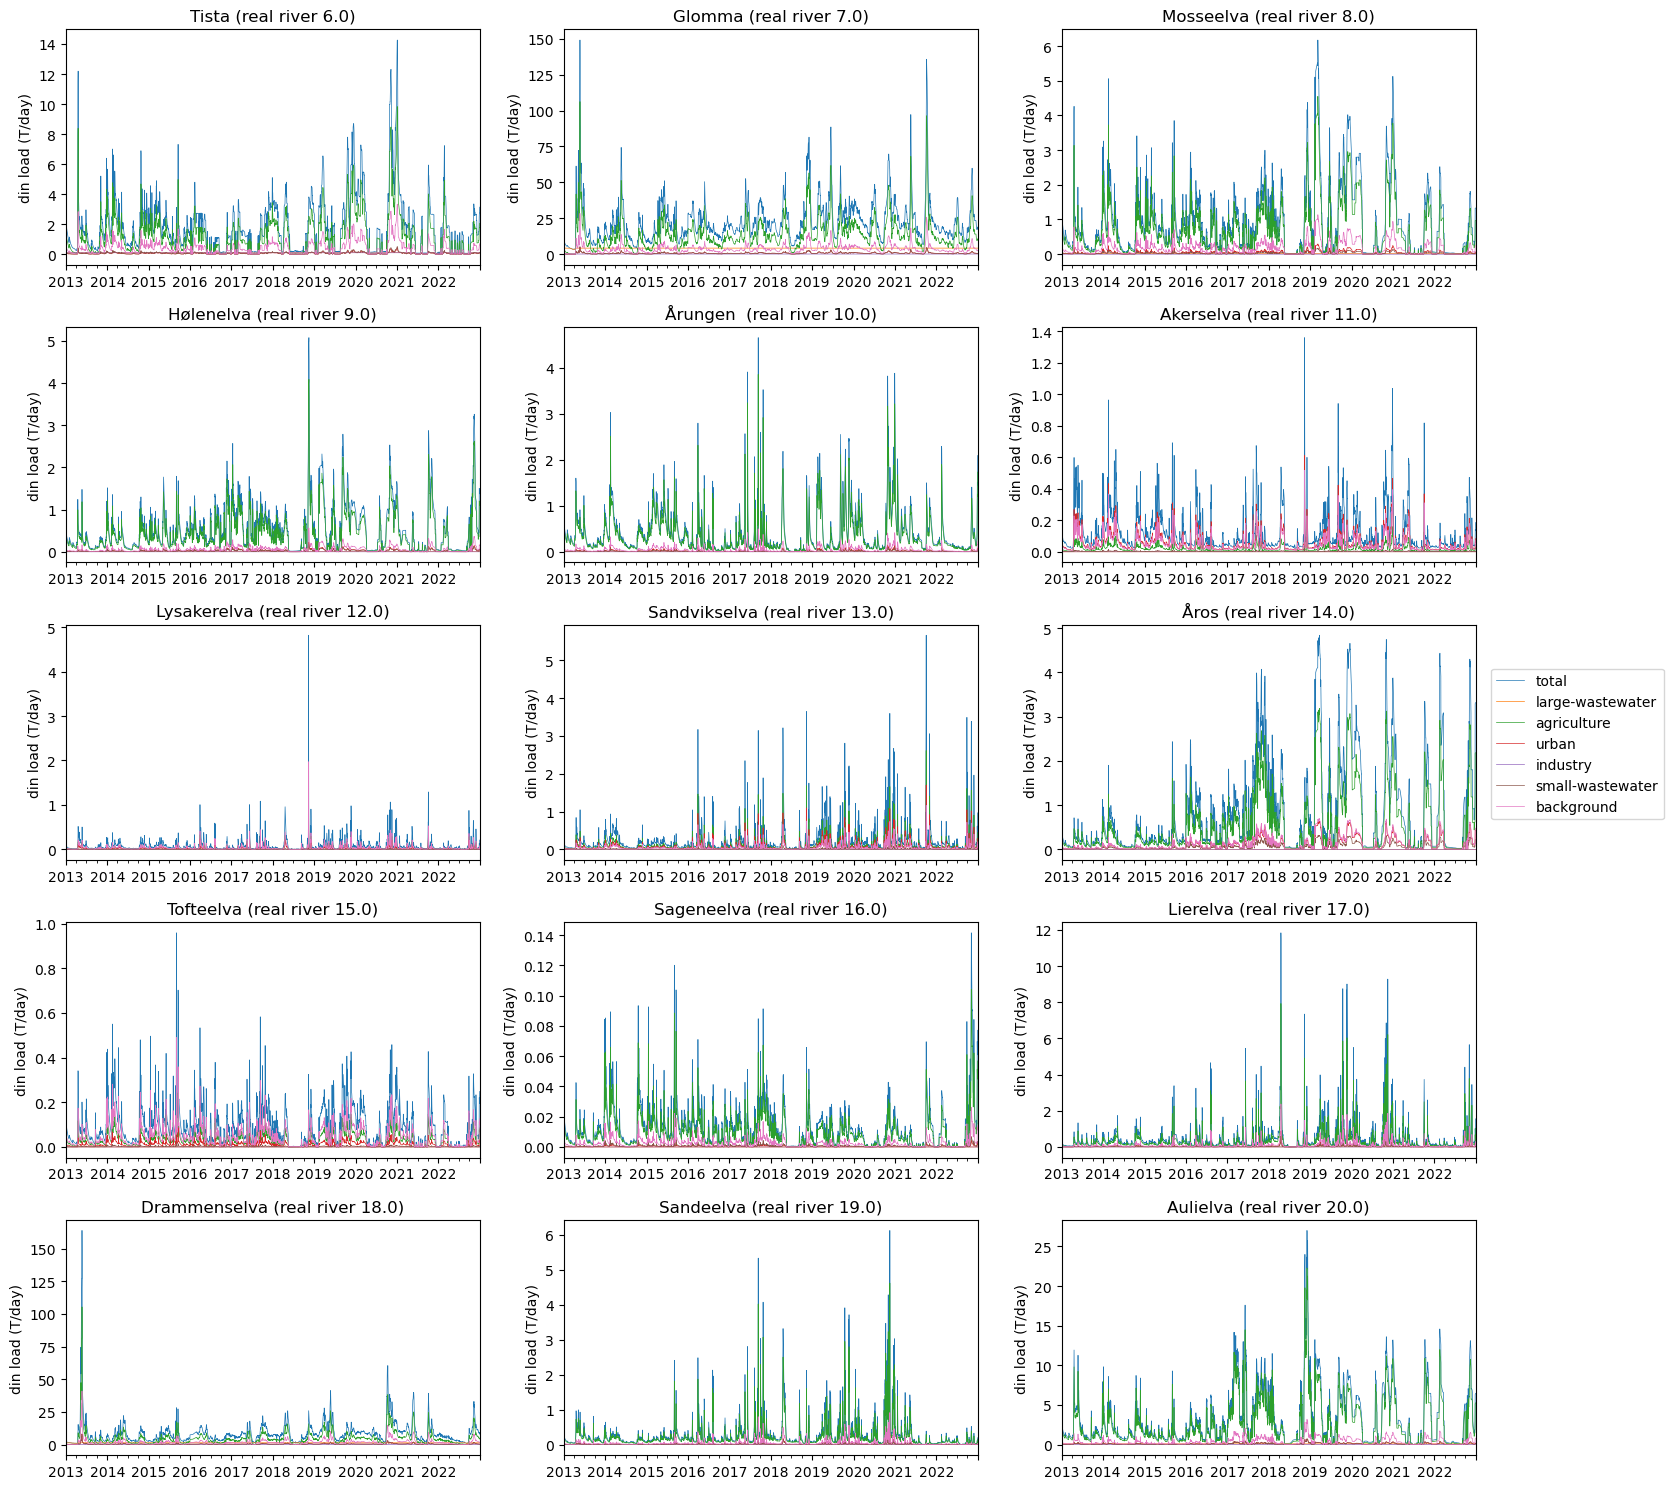

In [45]:
cols_to_plot = ['total', 'large-wastewater', 'agriculture', 'urban', 'industry', 'small-wastewater', 'background']

def plot_timeseries_allrivs(real_rivers_li, daily_load_dict, cols_to_plot):
    n_rows = int(np.ceil(len(real_rivers_li) / 3))
    fig, axs = plt.subplots(n_rows, 3, figsize=(15, n_rows*3), sharex=False, sharey=False)
    axs = axs.flatten()
    # color_li = ['k', 'r', '']

    # For each real_river
    for i, real_river in enumerate(real_rivers_li):
        name = river_meta_df.loc[real_river, 'river_name']
        df = daily_load_dict[real_river].copy()/1000  # to T/yr
        df[cols_to_plot].plot(ax=axs[i], linewidth=0.5, legend=False)
        axs[i].set_xlabel('')
        axs[i].set_ylabel(r'%s load (T/day)' % par)
        axs[i].set_title(f'{name} (real river {real_river})')

    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', bbox_to_anchor=(1.12, 0.5))

    plt.tight_layout()
    # fig.autofmt_xdate()
    plt.show()


plot_timeseries_allrivs(real_rivers, daily_load_dict, cols_to_plot)

# Generate scenarios

To do: move to new file

In [47]:
# Factor giving proportion of the original load per sector
# (i.e. new load = old load * factor)

# Read in scenarios info
# scen_setup_df = pd.read_csv(scenario_setup_fpath, index_col=0)

# Or input directly
scenario = 'A100'
scenario_dict = {
    "agriculture": 0,
    "industry": 1,
    "large-wastewater": 1,
    "small-wastewater": 1,
    "urban": 1,
    "background": 1
}
scen_setup_df = pd.DataFrame(list(scenario_dict.items()), columns=['Sector', scenario])
scen_setup_df.set_index('Sector', inplace=True)

scen_setup_df

,A100
Sector,
agriculture,0
industry,1
large-wastewater,1
small-wastewater,1
urban,1
background,1


In [62]:
main_results_dict = {}  # key: scenario. Returns [scenario_loads_dict, scenario_factor_dict]

for scenario in scen_setup_df.columns:

    scenario_loads_dict = {}
    scenario_factor_dict = {}
    scenario_conc_dict = {}  # Key: river

    for riv_no in daily_load_dict.keys():

        # Calculate loads per sector for the scenario
        baseline_df = daily_load_dict[riv_no].copy()

        scen_load_df = pd.DataFrame(index=baseline_df.index)

        for source in scen_setup_df.index:
            scen_load_df[source] = baseline_df[source] * scen_setup_df.loc[source, scenario]

        scen_load_df['total'] = scen_load_df.sum(axis=1)
        scenario_loads_dict[riv_no] = scen_load_df

        # ---------------------------------------------------------
        # Factor to multiply concentration by to get new concentration
        factor_s = scen_load_df['total'] / baseline_df['total']
        # Replace any NaNs with 1 (i.e. concentration is unchanged)
        factor_s.fillna(1, inplace=True)
        factor_s.name = 'factor'
        scenario_factor_dict[riv_no] = factor_s

        # ---------------------------------------------------------
        # Calculate new daily concentration: C_scenario = L_scenario / Q
        # or (equivalent): C_scenario = C_baseline * (L_scenario/L_baseline)
        scen_load_df = scen_load_df[["total"]].copy()
        scen_load_df.columns = [f"{par}_load"]

        # Adjust the time component of the datetime index to be centered on midday
        # to match chem_df
        scen_load_df.index = scen_load_df.index + pd.tseries.offsets.DateOffset(
            hours=12
        )
        factor_s = factor_s.copy()  # To not alter dictionary item inplace
        factor_s.index = factor_s.index + pd.tseries.offsets.DateOffset(hours=12)

        # Join new total load to conc_df, and the factor
        df = conc_df.loc[conc_df["real_river"] == riv_no].copy()
        df.set_index("river_time", inplace=True)
        df = pd.merge(
            df,
            scen_load_df[[f"{par}_load"]],
            left_index=True,
            right_index=True,
            how="left",
        )
        df = pd.merge(df, factor_s, left_index=True, right_index=True, how="left")

        # Calculate new value for par (two methods to validate; they produce the same result)
        # df[f"{par}_new"] = df['din_load'] / df['river_transport'] * 1/86400 * 10**9 * 10**-3
        df[f"{par}"] = df[f"{par}"] * df["factor"]

        if par == 'din':
            # Assume NH4 and NO3 are reduced by the same amount as din
            df['river_NH4N'] = df['river_NH4N'] * df["factor"]
            df['river_NO3NO2N'] = df['river_NO3NO2N'] * df["factor"]

            # Calculate new TOTN
            df['river_TOTN'] = df['din'] + df['river_DON'] + df['river_PON']

            # Drop cols used in calculation
            df.drop(derived_chemvar_dict[species] + [f"{par}_load", 'factor'], axis=1, inplace=True)

        # Bit of QC
        # Check for NaNs
        if df.isna().sum().sum() > 0:
            print(f"{riv_no} has NaNs. Needs fixing!")

        scenario_conc_dict[riv_no] = df

    main_results_dict[(scenario, 'loads')] = scenario_loads_dict
    main_results_dict[(scenario, 'factor')] = scenario_factor_dict
    main_results_dict[(scenario, 'conc')] = scenario_conc_dict

In [ ]:
# # Calculate new daily concentration: C_scenario = L_scenario / Q
# # or (equivalent): C_scenario = C_baseline * (L_scenario/L_baseline)

# scenario_conc_dict = {}  # Key: river

# for river_no in list(daily_load_dict.keys()):
#     scenario_load_df = scenario_loads_dict[river_no][["total"]].copy()
#     scenario_load_df.columns = [f"{par}_load"]
#     factor_s = scenario_factor_dict[river_no].copy()

#     # Adjust the time component of the datetime index to be centered on midday
#     # to match chem_df
#     scenario_load_df.index = scenario_load_df.index + pd.tseries.offsets.DateOffset(
#         hours=12
#     )
#     factor_s.index = factor_s.index + pd.tseries.offsets.DateOffset(hours=12)

#     # Join new total load to conc_df
#     df = conc_df.loc[conc_df["real_river"] == river_no].copy()
#     df.set_index("river_time", inplace=True)
#     df = pd.merge(
#         df,
#         scenario_load_df[[f"{par}_load"]],
#         left_index=True,
#         right_index=True,
#         how="left",
#     )
#     df = pd.merge(df, factor_s, left_index=True, right_index=True, how="left")

#     # Calculate new value for par (two methods to validate; they produce the same result)
#     # df[f"{par}_new"] = df['din_load'] / df['river_transport'] * 1/86400 * 10**9 * 10**-3
#     df[f"{par}"] = df[f"{par}"] * df["factor"]

#     if par == 'din':
#         # Assume NH4 and NO3 are reduced by the same amount as din
#         df['river_NH4N'] = df['river_NH4N'] * df["factor"]
#         df['river_NO3NO2N'] = df['river_NO3NO2N'] * df["factor"]

#         # Calculate new TOTN
#         df['river_TOTN'] = df['din'] + df['river_DON'] + df['river_PON']

#         # Drop cols used in calculation
#         df.drop(derived_chemvar_dict[species] + [f"{par}_load", 'factor'], axis=1, inplace=True)

#     # Bit of QC
#     # Check for NaNs
#     if df.isna().sum().sum() > 0:
#         print(f"{river_no} has NaNs. Needs fixing!")

#     scenario_conc_dict[river_no] = df

**Quick check of output**

In [58]:
main_results_dict.keys()

dict_keys([('A100', 'loads'), ('A100', 'factor'), ('A100', 'conc')])

In [63]:
riv = 7
scen = 'A100'

scenario_loads_dict = main_results_dict[(scen, 'loads')]
scenario_factor_dict = main_results_dict[(scen, 'factor')]
scenario_conc_dict = main_results_dict[(scen, 'conc')]

# Baseline loads per sector + total
daily_load_dict[riv].copy().loc['2013-02-20': '2013-02-28']

,total,diffuse,point,agriculture,small-wastewater,urban,industry,large-wastewater,background
date,,,,,,,,,
2013-02-20,4471.508077,164.940241,4306.567835,120.983260,5.906829,5.706011,100.080382,4206.487453,3.234414e+01
2013-02-21,4411.527088,104.959253,4306.567835,76.987353,3.758794,3.631004,100.080382,4206.487453,2.058210e+01
2013-02-22,4353.893759,47.325923,4306.567835,34.713448,1.694833,1.637213,100.080382,4206.487453,9.280430e+00
2013-02-23,4298.967060,0.000000,4298.967060,0.000000,0.000000,0.000000,99.903748,4199.063312,0.000000e+00
2013-02-24,4244.102082,0.000000,4244.102082,0.000000,0.000000,0.000000,98.628740,4145.473342,0.000000e+00
2013-02-25,4190.203613,0.000000,4190.203613,0.000000,0.000000,0.000000,97.376193,4092.827421,0.000000e+00
2013-02-26,4137.422037,0.000000,4137.422037,0.000000,0.000000,0.000000,96.149601,4041.272436,0.000000e+00
2013-02-27,4091.345778,0.000000,4091.345778,0.000000,0.000000,0.000000,95.078834,3996.266944,4.547474e-13
2013-02-28,4053.973312,0.000000,4053.973312,0.000000,0.000000,0.000000,94.210335,3959.762977,0.000000e+00


In [64]:
# Scenario loads
scenario_loads_dict[riv].copy().loc['2013-02-20': '2013-02-28']

,agriculture,industry,large-wastewater,small-wastewater,urban,background,total
date,,,,,,,
2013-02-20,0.0,100.080382,4206.487453,5.906829,5.706011,3.234414e+01,4350.524817
2013-02-21,0.0,100.080382,4206.487453,3.758794,3.631004,2.058210e+01,4334.539736
2013-02-22,0.0,100.080382,4206.487453,1.694833,1.637213,9.280430e+00,4319.180311
2013-02-23,0.0,99.903748,4199.063312,0.000000,0.000000,0.000000e+00,4298.967060
2013-02-24,0.0,98.628740,4145.473342,0.000000,0.000000,0.000000e+00,4244.102082
2013-02-25,0.0,97.376193,4092.827421,0.000000,0.000000,0.000000e+00,4190.203613
2013-02-26,0.0,96.149601,4041.272436,0.000000,0.000000,0.000000e+00,4137.422037
2013-02-27,0.0,95.078834,3996.266944,0.000000,0.000000,4.547474e-13,4091.345778
2013-02-28,0.0,94.210335,3959.762977,0.000000,0.000000,0.000000e+00,4053.973312


In [65]:
# Factor for calculating concs
scenario_factor_dict[riv].loc['2013-02-20': '2013-02-28']

date
2013-02-20    0.972944
2013-02-21    0.982549
2013-02-22    0.992027
2013-02-23    1.000000
2013-02-24    1.000000
2013-02-25    1.000000
2013-02-26    1.000000
2013-02-27    1.000000
2013-02-28    1.000000
Name: factor, dtype: float64

In [66]:
# Original conc
conc_df.loc[conc_df["real_river"] == riv].set_index('river_time').loc['2013-02-20': '2013-02-28']

,real_river,river_NH4N,river_NO3NO2N,river_TOTN,river_DON,river_PON,river_transport,din,ton
river_time,,,,,,,,,
2013-02-20 12:00:00,7.0,38.369,375.727,552.318,133.122,5.054,124.979630,414.096008,138.222000
2013-02-21 12:00:00,7.0,39.442,374.956,551.807,131.442,5.913,123.212997,414.398987,137.408997
2013-02-22 12:00:00,7.0,40.523,374.170,551.435,129.924,6.758,121.517097,414.692993,136.742996
2013-02-23 12:00:00,7.0,41.578,373.393,551.111,128.512,7.559,119.903709,414.971008,136.139999
2013-02-24 12:00:00,7.0,42.552,372.667,550.854,127.278,8.283,118.302757,415.218994,135.634995
2013-02-25 12:00:00,7.0,43.400,372.027,550.680,126.266,8.906,116.741875,415.427002,135.253006
2013-02-26 12:00:00,7.0,44.099,371.491,550.589,125.492,9.422,115.226135,415.589996,135.000000
2013-02-27 12:00:00,7.0,44.646,371.063,550.578,124.945,9.834,113.910301,415.709015,134.869003
2013-02-28 12:00:00,7.0,45.054,370.736,550.634,124.598,10.153,112.847534,415.790985,134.843994


In [54]:
# New concs
scenario_conc_dict[riv].loc['2013-02-20': '2013-02-28']

,real_river,river_NH4N,river_NO3NO2N,river_TOTN,river_DON,river_PON,river_transport
river_time,,,,,,,
2013-02-20 12:00:00,7.0,37.330870,365.561151,541.068029,133.122,5.054,124.979630
2013-02-21 12:00:00,7.0,38.753682,368.412490,544.522142,131.442,5.913,123.212997
2013-02-22 12:00:00,7.0,40.199911,371.186755,548.068660,129.924,6.758,121.517097
2013-02-23 12:00:00,7.0,41.578000,373.393000,551.042008,128.512,7.559,119.903709
2013-02-24 12:00:00,7.0,42.552000,372.667000,550.779994,127.278,8.283,118.302757
2013-02-25 12:00:00,7.0,43.400000,372.027000,550.599002,126.266,8.906,116.741875
2013-02-26 12:00:00,7.0,44.099000,371.491000,550.503996,125.492,9.422,115.226135
2013-02-27 12:00:00,7.0,44.646000,371.063000,550.488015,124.945,9.834,113.910301
2013-02-28 12:00:00,7.0,45.054000,370.736000,550.541985,124.598,10.153,112.847534


## Generate netcdf files

Read in Phil's original file, truncate to the period I've updated (i.e. the date which TEOTIL covers), and then update the concentration columns for the variables that have been updated through the scenario.

In [70]:
for scenario in scen_setup_df.columns:

    # scenario_loads_dict = main_results_dict[(scen, 'loads')]
    # scenario_factor_dict = main_results_dict[(scen, 'factor')]
    scenario_conc_dict = main_results_dict[(scen, 'conc')]

    update_cols_li = ["river_NH4N", "river_NO3NO2N", "river_TOTN"]

    # Read in original river file & truncate to start and end date of scenarios
    ds_scen = xr.open_dataset(fpath_baseline_data)
    ds_scen = ds_scen.sel(river_time=slice(start_date, end_date))
    # print(ds_scen.river_time.data[-1])  # Check not chopped end: ok

    # Update the relevant chemistry values
    for real_river, df in scenario_conc_dict.items():
        df = df.copy().reset_index()  # To not modify it inplace
        df_ds = xr.Dataset.from_dataframe(df)
        for col in update_cols_li:
            ds_scen[col].loc[
                {"real_river": real_river, "river_time": df_ds["river_time"]}
            ] = df_ds[col]

    # Update the 'History' attribute of the ds_scen dataset
    current_date = dt.datetime.now().date().strftime("%Y-%m-%d")
    existing_history = ds_scen.attrs["history"]
    new_history_str = (
        f"; Update {current_date}, Leah JB (NIVA, ljb@nivano): "
        "This is a daily concentration reduction scenario. See 'make_scenarios.ipynb', "
        "GitHub repository https://github.com/oslofjord-load-reductions/terrestrial-load-scenarios"
    )
    new_history = existing_history + new_history_str
    ds_scen.attrs['history'] = new_history

    # Save
    netcdf_fpath = os.path.join(netcdf_outfolder, f"river_din_reduction_{scenario}_v1.nc")
    ds_scen.to_netcdf(netcdf_fpath)
    ds_scen.close()

# Plot results

In [67]:
ds_bsl = xr.open_dataset(fpath_baseline_data)
ds_bsl = ds_bsl.sel(river_time=slice(start_date, end_date))

In [ ]:
riv_no = 18
var = "river_NO3NO2N"
st_dt = "2013-01-01"
end_ds_dt = "2015-01-01"
end_df_dt = "2014-12-31"

name = river_meta_df.loc[riv_no, "river_name"]

# Select the data

# Concentration data
# plot_conc_df = scenario_conc_dict[riv_no].copy()
# plot_conc_df = plot_conc_df.loc[st_dt: end_df_dt, :]

plot_bsl_ds = ds_bsl.sel(real_river=riv_no) #, river_time=slice(st_dt, end_ds_dt))
plot_scen_ds = ds_scen.sel(real_river=riv_no) #, river_time=slice(st_dt, end_ds_dt))

# Loads data
plot_bsl_load_df = daily_load_dict[riv_no][["total"]].copy() / 1000 #.loc[st_dt:end_df_dt, :] / 1000
plot_scen_load_df = (
    scenario_loads_dict[riv_no][["total"]]
    .copy() / 1000
    # .loc[st_dt : end_df_dt, :]
)

# Plot
fig, axs = plt.subplots(2, 1, figsize=(15, 6), sharex=True, sharey=False)
axs = axs.flatten()

# Plot loads
axs[0].plot(plot_bsl_load_df.index.values, plot_bsl_load_df["total"], label="baseline")
axs[0].plot(
    plot_scen_load_df.index.values, plot_scen_load_df["total"], label="scenario"
)
axs[0].set_ylabel("NOx load (T/d)")

# Plot concentrations
# axs[1].plot(plot_conc_df .index, plot_conc_df [var], label='df')
axs[1].plot(plot_bsl_ds["river_time"].values, plot_bsl_ds[var].values, label="baseline")
axs[1].plot(
    plot_scen_ds["river_time"].values, plot_scen_ds[var].values, label="scenario"
)

# Tidy up & save
axs[1].set_ylabel("NOx conc (ug/l)")
axs[0].legend()
plt.suptitle(f'{riv_no}: {name}')
plt.tight_layout()
plt.show()